In [29]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools

from parser.loans_volume_msp import get_measures, get_loans_volume_msp_df
from data_transform.transform_df import transform_df_to_format

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [36]:
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - pred) / actual_safe))*100

def region_predict(key, value):
    # временная заглушка
    df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=False, measure_id=key))
    # Извлекаем год из столбца "Отчетный период"
    df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
    # Формируем новый столбец "Дата" в формате YYYY-MM
    df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    # Удаляем временные столбцы
    df = df[['date', 'msp_loans_volume']]
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    train_size = int(0.85 * len(df))
    test_size = len(df) - train_size
    split_date = df['date'].iloc[train_size]
    train = df[df['date']<split_date]
    test = df[df['date']>=split_date]
    # Делаем из датафреймов серии
    trn_ser = train.copy()
    trn_ser.set_index(keys='date', drop=True, inplace=True)
    trn_ser = trn_ser.squeeze(axis=1)
    tst_ser = test.copy()
    tst_ser.set_index(keys='date', drop=True, inplace=True)
    tst_ser = tst_ser.squeeze(axis=1)
    # ОБУЧЕНИЕ МОДЕЛИ
    model = SARIMAX(trn_ser, order=(1,1,1), seasonal_order=(1,1,1,12), trend='ct' , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
    model_fit = model.fit() 
    pred = model_fit.get_prediction(start=split_date, end='2026-03-01', dynamic=False)
    vol_diff_pred = pred.predicted_mean
    test_pred = vol_diff_pred[0:test_size]
    mp = mape(tst_ser.values, test_pred.values)
    print(mp)
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
    plt.plot(vol_diff_pred / 1e6)
    plt.xlabel('date')
    plt.ylabel('Объем кредитов, трлн руб.')
    plt.title(value)
    plt.grid(True)
    plt.show()

In [37]:
regions = get_measures()

for key,value in regions.items():
    print(key, ' - ', value)


22  -  Российская Федерация
23  -  Центральный федеральный округ
24  -  Белгородская область
25  -  Брянская область
26  -  Владимирская область
27  -  Воронежская область
28  -  Ивановская область
29  -  Калужская область
30  -  Костромская область
31  -  Курская область
32  -  Липецкая область
33  -  Московская область
34  -  Орловская область
35  -  Рязанская область
36  -  Смоленская область
37  -  Тамбовская область
38  -  Тверская область
39  -  Тульская область
40  -  Ярославская область
41  -  г. Москва
42  -  Северо-Западный федеральный округ
43  -  Республика Карелия
44  -  Республика Коми
45  -  Архангельская область
46  -  Архангельская область, в том числе Ненецкий автономный округ
47  -  Архангельская область без данных по Ненецкому автономному округу
48  -  Вологодская область
49  -  Калининградская область
50  -  Ленинградская область
51  -  Мурманская область
52  -  Новгородская область
53  -  Псковская область
54  -  г. Санкт-Петербург
55  -  Южный федеральный округ
5

11.82232110247065


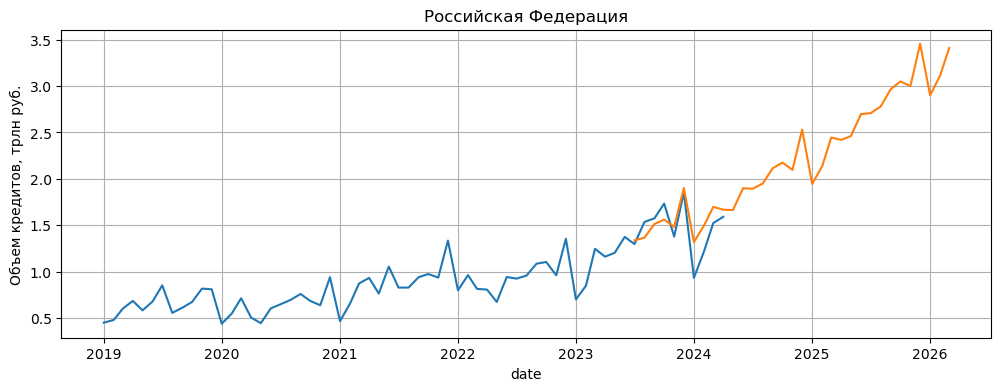

24.889440726798462


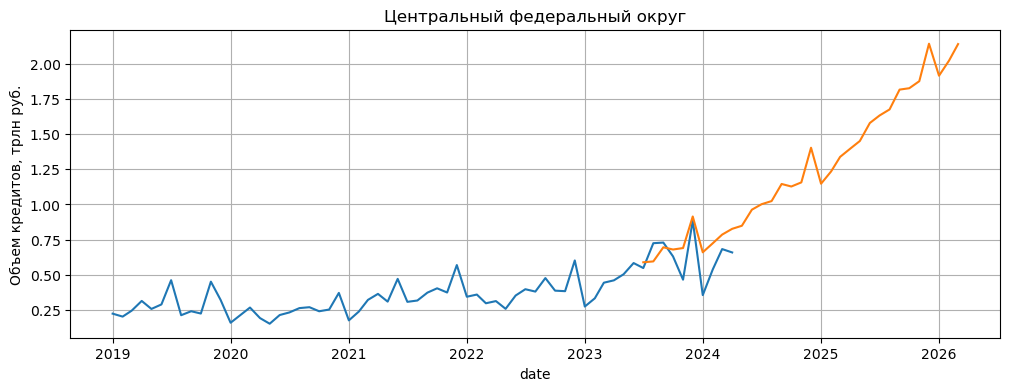

24.309204568036744


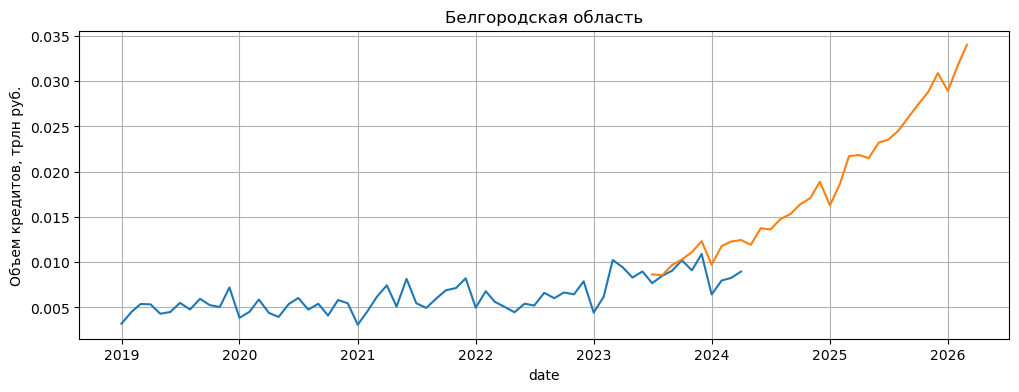

In [39]:
for key,value in regions.items():
    if key < 25:
        region_predict(key, value)